## Case 1: Train different anomaly detection networks dynamically over time

#### MIX MNIST:
Advantages of Automated Meter Reading with Computer Vision 
The implementation of Computer Vision for automated meter reading offers a compelling suite of benefits 

- Real-Time Monitoring: Continuous tracking of pressure, temperature, and liquid levels enables instant detection of fluctuations, preventing potential failures or safety risks. 
- Increased Accuracy: Eliminates human errors in reading analog and digital meters, ensuring precise measurements and reliable data. 
- Enhanced Safety: Reduces the need for manual inspections in hazardous or hard-to-reach locations, minimizing worker exposure to risks. 
- Operational Efficiency: Automates data collection, reducing the need for frequent manual checks and allowing personnel to focus on higher-value tasks. 
- Predictive Maintenance: Provides historical data and trend analysis, helping industries detect anomalies early and schedule maintenance before failures occur. 
- Remote Accessibility: Enables monitoring from centralized control rooms or remote locations, reducing labor costs and improving response times. 


https://imagevision.ai/blog/automated-meter-reading-using-computer-vision-for-industrial-plants-to-enhance-data-logging/?utm_source=chatgpt.com

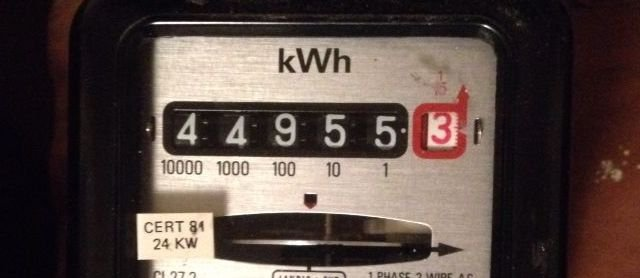
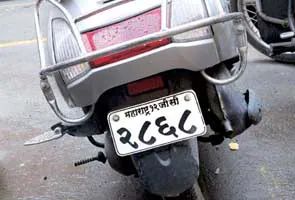

In [1]:
all_languages = ["Arabic","ARDIS","Bangla","BanglaLekha","Devanagari","EMNIST",
 "Farsi","ISI_Bangla","Kannada","MADBase","Telugu","Tibetan","Urdu"]
_main_ = ["MNIST_MIX"]
# we use:
used_languages = ["EMNIST","Farsi","Urdu","Kannada"]

In [1]:
import numpy as np
import torch
from typing import Dict, Tuple, Iterable
import torchvision.transforms as transforms
from numpy.typing import NDArray
import torchvision.transforms as transforms
from torch.utils.data import Dataset

class MIXMNIST_BASE:
    def __init__(self, root:str='./data', prefix:str=""):
        self.root = root
        self.prefix = prefix
        self.transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
        )
        self.datasets = self._get_dataset()

    def _get_dataset(self) -> Dict[str,Tuple[NDArray,NDArray]]:
        # NpzFile '{...}_train_test.npz' with keys: X_train, X_test, y_train, y_test
        loaded:Dict[str,NDArray] = np.load(f'{self.root}/MNIST-MIX-all/{self.prefix}_train_test.npz')
        raw_dataset = {
            'train': (loaded['X_train'], loaded['y_train']),
            'test': (loaded['X_test'], loaded['y_test'])
        }
        formatted_dataset = {}
        for split_name, (imgs, targets) in raw_dataset.items():
            formatted_items = []
            for i, img in enumerate(imgs):

                if self.transform:
                    img = self.transform(img)
                formatted_items.append((img, int(targets[i])))
            formatted_dataset[split_name] = formatted_items
        return formatted_dataset

class MIXMNIST(Dataset):
    def __init__(self, root: str = './data', prefix: str = "", subset: str = "train"):
        self.base = MIXMNIST_BASE(root=root, prefix=prefix)
        self.subset = subset
        print(f"Dataset Created for MIX MNIST: {prefix}-{subset}")

    def __getitem__(self, item: int) -> torch.Tensor:
        return self.base.datasets[self.subset][int(item[0])][0]
    
    def __len__(self) -> int:
        length = len(self.base.datasets[self.subset])
        return length

# datasets = MIXMNIST_BASE(prefix="Bangla").datasets

In [2]:
import random
from typing import Callable, List, Iterable, Tuple, Optional

from problog.logic import Term, list2term, Constant
from torch.utils.data import Dataset as TensorDataset
from deepproblog.dataset import Dataset
from deepproblog.query import Query

class MNISTOperator(Dataset, TensorDataset):
    def __getitem__(self, index: int) -> Tuple[list, list, int]:
        l1, l2 = self.data[index]
        print("L1L2",l1,l2)
        label = self._get_label(index)
        l1 = [self.dataset[x][0] for x in l1]
        l2 = [self.dataset[x][0] for x in l2]
        return l1, l2, label

    def __init__(
        self,
        dataset_name: str,
        function_name: str,
        operator: Callable[[List[int]], int],
        size=1,
        arity=2,
        seed=None,
        prefix="None",
        max_examples: Optional[int] = None  # 新增参数：限制最大样本数
    ):
        """Generic dataset for operator(img, img) style datasets.

        :param dataset_name: Dataset to use (train, val, test)
        :param function_name: Name of Problog function to query.
        :param operator: Operator to generate correct examples
        :param size: Size of numbers (number of digits)
        :param arity: Number of arguments for the operator
        :param seed: Seed for RNG
        :param prefix: Prefix for dataset
        :param max_examples: Maximum number of examples to generate (None for unlimited)
        """
        super(MNISTOperator, self).__init__()
        assert size >= 1
        assert arity >= 1
        self.dataset_name = dataset_name
        self.dataset = (MIXMNIST_BASE(prefix=prefix).datasets)[self.dataset_name]
        self.function_name = function_name
        self.operator = operator
        self.size = size
        self.arity = arity
        self.seed = seed
        self.max_examples = max_examples
        
        mnist_indices = list(range(len(self.dataset)))
        if seed is not None:
            rng = random.Random(seed)
            rng.shuffle(mnist_indices)
        dataset_iter = iter(mnist_indices)
        
        # Build list of examples (mnist indices): [[2,3],[5,7],...] a list of arities of each query
        self.data = []
        example_count = 0
        
        try:
            while True:

                if self.max_examples is not None and example_count >= self.max_examples:
                    break
                    
                self.data.append(
                    [
                        [next(dataset_iter) for _ in range(self.size)]
                        for _ in range(self.arity)
                    ]
                )
                example_count += 1
                
        except StopIteration:
            pass
        
        print(f"Generated {len(self.data)} examples (max_examples={self.max_examples})")

    def _dig2num(self, digits:List[int]) -> int:
        number = 0
        for d in digits:
            number *= 10
            number += d
        return number

    def to_query(self, i: int) -> Query:
        """Generate queries"""
        mnist_indices = self.data[i]
        expected_result = self._get_label(i)

        # Build substitution dictionary for the arguments
        subs = dict()
        var_names = []
        for i in range(self.arity):
            inner_vars = []
            for j in range(self.size):
                t = Term(f"p{i}_{j}")
                subs[t] = Term(
                    "tensor",
                    Term(
                        self.dataset_name,
                        Constant(mnist_indices[i][j]),
                    ),
                )
                inner_vars.append(t)
            var_names.append(inner_vars)

        # Build query
        if self.size == 1:
            args = [e[0] for e in var_names]
        else:
            args = [list2term(e) for e in var_names]

        return Query(
            Term(
                self.function_name,
                *args,
                Constant(expected_result),
            ),
            subs,
        )

    def _get_label(self, i: int):
        mnist_indices = self.data[i]
        # Figure out what the ground truth is, first map each parameter to the value:
        ground_truth = []
        for idx_tuple in mnist_indices:
            digits = [self.dataset[j][1] for j in idx_tuple]
            number = self._dig2num(digits)
            ground_truth.append(number)

        # Then compute the expected value:
        expected_result = self.operator(ground_truth)
        return expected_result

    def __len__(self):
        print("call __len__ Operator:",len(self.data))
        return len(self.data)

def operation(n: int, dataset: str, prefix: str, func: callable, seed=None, max_examples: Optional[int] = None):
    """Returns a dataset for binary addition
    
    :param max_examples: Maximum number of examples to generate (e.g., 2000)
    """
    return MNISTOperator(
        dataset_name=dataset,
        function_name="anomaly_detection",
        operator=func,
        size=n,
        arity=2,
        seed=seed,
        prefix=prefix,
        max_examples=max_examples 
    )

In [3]:
"""1. If the user is in Saudi Arabia, check machine overheating anomaly:
   - If Temperature ≥ 60°C AND Flow rate ≤ 20 L/min, there's anomaly
   - number(Digit1, Temp), number(Digit2, Flow)

2. If the user is in Iraq, check storage tank Level anomaly:
   - If LiquidLevel ≥ 75% OR Pressure ≥ 15 bar, there's anomaly
   - number(Digit1, LiquidLevel), number(Digit2, Pressure)

3. If the user is in India, check power overload anomaly:
   - If sum of branch currents > 120A, there's anomaly
   - number(Digit1, Current1), number(Digit2, Current2)

4. If the user is in Urdu regions (Pakistan), check network traffic anomaly:
   - If the source IP equals destination IP, there's anomaly
   - number(Digit1, SourceIP), number(Digit2, DestIP)"""

"1. If the user is in Saudi Arabia, check machine overheating anomaly:\n   - If Temperature ≥ 60°C AND Flow rate ≤ 20 L/min, there's anomaly\n   - number(Digit1, Temp), number(Digit2, Flow)\n\n2. If the user is in Iraq, check storage tank Level anomaly:\n   - If LiquidLevel ≥ 75% OR Pressure ≥ 15 bar, there's anomaly\n   - number(Digit1, LiquidLevel), number(Digit2, Pressure)\n\n3. If the user is in India, check power overload anomaly:\n   - If sum of branch currents > 120A, there's anomaly\n   - number(Digit1, Current1), number(Digit2, Current2)\n\n4. If the user is in Urdu regions (Pakistan), check network traffic anomaly:\n   - If the source IP equals destination IP, there's anomaly\n   - number(Digit1, SourceIP), number(Digit2, DestIP)"

### TEST:

In [4]:
from json import dumps
import sys
from pathlib import Path

import torch
from typing import Dict, Tuple, Iterable, Literal

from deepproblog.dataset import DataLoader
from deepproblog.engines import ApproximateEngine, ExactEngine
from deepproblog.evaluate import get_confusion_matrix
from deepproblog.examples.MNIST.network import MNIST_Net
from deepproblog.model import Model
from deepproblog.network import Network
from deepproblog.train import train_model

from langda import langda_solve

current_dir = "examples/mixmnist"

# examples for testing.
query_ext = """digit(img_1,1).
arabic_digit(img_5,5).
arabic_digit(img_9,9).
arabic_digit(img_1,1).
telugu_digit(img_5,5).
telugu_digit(img_9,9).
telugu_digit(img_1,1).
kannada_digit(img_5,5).
kannada_digit(img_9,9).
kannada_digit(img_1,1).
query(anomaly_detection([img_1, img_9], [img_5, img_1], 1)).
query(anomaly_detection([img_9, img_1], [img_1, img_5], 1)).
query(anomaly_detection([img_5, img_1], [img_5, img_1], 1)).
query(anomaly_detection([img_9, img_5], [img_5, img_9], 1))."""

problog_string = """
% Neural network definitions for different languages
nn(arabic_net,[X],Y,[0,1,2,3,4,5,6,7,8,9]) :: arabic_digit(X,Y).
nn(telugu_net,[X],Y,[0,1,2,3,4,5,6,7,8,9]) :: telugu_digit(X,Y).
nn(kannada_net,[X],Y,[0,1,2,3,4,5,6,7,8,9]) :: kannada_digit(X,Y).

% Convert digit list to number
number([],Result,Result).
number([H|T],Acc,Result) :- 
    langda(LLM:"According to the current coordinate of user: /* Coordinate */ , search for the country of user is in, and the local languange they use, 
    and replace the 'digit(H,Nr)' here, with the appropriate language-specific digit predicate",LOT:"search"), 
    Acc2 is Nr+10*Acc, number(T,Acc2,Result).
number(X,Y) :- number(X,0,Y).

% Anomaly detection logic - Result is 1 if anomaly detected, 0 otherwise
anomaly_detection(Digit1, Digit2, 1) :- 
    langda(LLM:"According to the current country the user is in, retrieve the rule in database with country name, and generate the complete anomaly detection rule using the appropriate logic and digit conversion.",LOT:"retrieve").

anomaly_detection(Digit1, Digit2, 0) :- \+ anomaly_detection(Digit1, Digit2, 1).
"""

def different_languange_test(MIXMNIST_train, MIXMNIST_test, train_set, test_set, train:bool, load_pretrained:bool, load_rule:bool, prompt_from_expert, save_to, rule_set, epoch=5):
    # *** ================= *** =========== *** ================= *** 
    name = "language_{}_{}".format(save_to, 2)
    result_string = langda_solve("double_dc", 
                                 problog_string,
                                 model_name = "deepseek-chat",

                                prefix=f"{rule_set}",
                                save_dir=current_dir,
                                load=load_rule,
                                langda_ext={"Coordinate":prompt_from_expert},
                                query_ext=query_ext,
                                 )

    print(result_string)
    network1 = MNIST_Net()
    network2 = MNIST_Net()
    network3 = MNIST_Net()
    network4 = MNIST_Net()

    net1 = Network(network1, "arabic_net", batching=True)
    net1.optimizer = torch.optim.Adam(network1.parameters(), lr=5e-4)
    net2 = Network(network2, "telugu_net", batching=True)
    net2.optimizer = torch.optim.Adam(network2.parameters(), lr=5e-4)
    net3 = Network(network3, "kannada_net", batching=True)
    net3.optimizer = torch.optim.Adam(network3.parameters(), lr=5e-4)
    net4 = Network(network4, "urdu_net", batching=True)
    net4.optimizer = torch.optim.Adam(network4.parameters(), lr=5e-4)

    model = Model(result_string, [net1,net2,net3,net4], load=False)
    model.set_engine(ExactEngine(model), cache=True)

    model.add_tensor_source("train", MIXMNIST_train)
    model.add_tensor_source("test", MIXMNIST_test)
    if load_pretrained:
        try:
            model.load_state("snapshot/{}.pth".format(name))
        except:
            print(f"No local model:{name} found, train it first.")
            pass

    if train:
        loader = DataLoader(train_set, 1, False)
        train = train_model(model, loader, epoch, log_iter=100, profile=0)
        model.save_state("snapshot/{}.pth".format(name))
        train.logger.comment(dumps(model.get_hyperparameters()))
        print(f"\nFinish Training!")
        train.logger.comment(
            "Accuracy {}".format(get_confusion_matrix(model, test_set, verbose=1).accuracy())
        )
        train.logger.write_to_file("log/" + name)
    else:
        if load_pretrained:
            try:
                model.load_state("snapshot/{}.pth".format(name))
            except:
                print(f"No local model:{name} found, train it first.")
                pass
        model.eval()
        confusion_matrix = get_confusion_matrix(model, test_set, verbose=1)
        accuracy = confusion_matrix.accuracy()

        print(f"\nFinish Testing!")
        print(f"Accuracy: {accuracy:.4f}")


### The user is now in Saudi Arabia
Arabic_digit: Coordinates (24.7136° N, 46.6753° E) => engine overheating anomaly

In [16]:
"""初始准确率
call __len__ Operator: 150
         	 	Actual	  
         	 	     1	 0
Predicted	1	    82	68
         	0	     0	 0
Accuracy:  0.5466666666666666
Accuracy 0.5466666666666666
Accuracy:  0.5466666666666666

Finish Testing!
Accuracy: 0.5467
"""
# =================== Real World Information =================== #
def machine(input:Iterable[int | bool]):
    return 1 if (input[0] >= 60 or input[1] <= 20) else 0
# Tensor Sources:
MIXMNIST_train = MIXMNIST(prefix="Arabic", subset="train") # prefix: load dataset: {prefix}_train_test.npz
MIXMNIST_test = MIXMNIST(prefix="Arabic", subset="test")
# Rules:
train_set = operation(2, "train", "Arabic", machine, seed=42)
test_set = operation(2, "test", "Arabic", machine, seed=42)

# Prompt:
rule_set = "arabic"
prompt_from_gps = "(24.7136° N, 46.6753° E)"
# =================== Our Model =================== #
for round in range(5):
	different_languange_test(MIXMNIST_train, MIXMNIST_test, train_set, test_set, train=True, load_pretrained=False, load_rule=True, prompt_from_expert=prompt_from_gps, save_to=f"one4all_{round}",rule_set=rule_set,epoch=5)

Dataset Created for MIX MNIST: Arabic-train
Dataset Created for MIX MNIST: Arabic-test
Generated 600 examples (max_examples=None)
Generated 150 examples (max_examples=None)
### =========== processing init_node =========== ###
[{'LOT': 'search', 'NET': None, 'LLM': "According to the current coordinate of user: /* Coordinate */ , search for the country of user is in, and the local languange they use, \n and replace the 'digit(H,Nr)' here, with the appropriate language-specific digit predicate", 'FUP': 'True', 'HEAD': 'number([H|T],Acc,Result) ', 'HASH': 'BD19A7AF'}, {'LOT': 'retrieve', 'NET': None, 'LLM': 'According to the current country the user is in, retrieve the rule in database with country name, and generate the complete anomaly detection rule using the appropriate logic and digit conversion.', 'FUP': 'True', 'HEAD': 'anomaly_detection(Digit1, Digit2, 1) ', 'HASH': 'FE7CA768'}]
{'BD19A7AF': 'arabic_digit(H,Nr)', 'FE7CA768': 'number(Digit1, Temp), number(Digit2, Flow), (Temp >= 60 

### The user is now in Iraq
Arabic_digit: Coordinates (33.3152° N, 44.3661° E) => tank Level anomaly

In [23]:
""" 
在训练之前, 使用未训练的网络进行测试:
call __len__ Operator: 150
         	 	Actual	  
         	 	     1	 0
Predicted	1	     0	 0
         	0	    67	83
Accuracy:  0.5533333333333333
Accuracy 0.5533333333333333
Accuracy:  0.5533333333333333


在训练之前, 直接使用沙特的网络进行测试:
Caching ACs
call __len__ Operator: 150
         	 	Actual	  
         	 	     1	 0
Predicted	1	    59	15
         	0	     8	68
Accuracy:  0.8466666666666667
Accuracy 0.8466666666666667
Accuracy:  0.8466666666666667
Caching ACs
call __len__ Operator: 150
         	 	Actual	  
         	 	     1	 0
Predicted	1	    58	14
         	0	     9	69
Accuracy:  0.8466666666666667
Accuracy 0.8466666666666667
Accuracy:  0.8466666666666667
Caching ACs
call __len__ Operator: 150
         	 	Actual	  
         	 	     1	 0
Predicted	1	    57	15
         	0	    10	68
Accuracy:  0.8333333333333334
Accuracy 0.8333333333333334
Accuracy:  0.8333333333333334
Caching ACs
call __len__ Operator: 150
         	 	Actual	  
         	 	     1	 0
Predicted	1	    60	15
         	0	     7	68
Accuracy:  0.8533333333333334
Accuracy 0.8533333333333334
Accuracy:  0.8533333333333334
Caching ACs
call __len__ Operator: 150
         	 	Actual	  
         	 	     1	 0
Predicted	1	    56	13
         	0	    11	70
Accuracy:  0.84
Accuracy 0.84
Accuracy:  0.84


wow结果非常好
"""


# =================== Real World Information =================== #
def heat_exchanger(input:Iterable[int | bool]):
    return 1 if input[0] < input[1] else 0
# Tensor Sources:
MIXMNIST_train = MIXMNIST(prefix="Arabic", subset="train") # prefix: load dataset: {prefix}_train_test.npz
MIXMNIST_test = MIXMNIST(prefix="Arabic", subset="test")
# Rules:
train_set = operation(2, "train", "Arabic", heat_exchanger, seed=42)
test_set = operation(2, "test", "Arabic", heat_exchanger, seed=42)

# =================== Our Model =================== #
rule_set = "iraq"
prompt_from_gps = "(33.3152° N, 44.3661° E)"

# =================== Our Model =================== #
for round in range(5):
	different_languange_test(MIXMNIST_train, MIXMNIST_test, train_set, test_set, train=True, load_pretrained=False, load_rule=True, prompt_from_expert=prompt_from_gps, save_to=f"one4all_{round}",rule_set=rule_set,epoch=5)

Dataset Created for MIX MNIST: Arabic-train
Dataset Created for MIX MNIST: Arabic-test
Generated 600 examples (max_examples=None)
Generated 150 examples (max_examples=None)
### =========== processing init_node =========== ###
[{'LOT': 'search', 'NET': None, 'LLM': "According to the current coordinate of user: /* Coordinate */ , search for the country of user is in, and the local languange they use, \n and replace the 'digit(H,Nr)' here, with the appropriate language-specific digit predicate", 'FUP': 'True', 'HEAD': 'number([H|T],Acc,Result) ', 'HASH': 'BD19A7AF'}, {'LOT': 'retrieve', 'NET': None, 'LLM': 'According to the current country the user is in, retrieve the rule in database with country name, and generate the complete anomaly detection rule using the appropriate logic and digit conversion.', 'FUP': 'True', 'HEAD': 'anomaly_detection(Digit1, Digit2, 1) ', 'HASH': 'FE7CA768'}]
{'BD19A7AF': 'arabic_digit(H,Nr)', 'FE7CA768': 'number(Digit1, Inlet), number(Digit2, Outlet), Inlet < O

### The user is now in India (There are two languages)
Coordinates (16.5062° N, 80.6480° E) => 
Corresponding city: Vijayawada, Andhra Pradesh, India => Telugu digits (telugu_digit) => power overload anomaly

In [ ]:
"""
% Neural network definitions for different languages
nn(arabic_net,[X],Y,[0,1,2,3,4,5,6,7,8,9]) :: arabic_digit(X,Y).
nn(telugu_net,[X],Y,[0,1,2,3,4,5,6,7,8,9]) :: telugu_digit(X,Y).
nn(kannada_net,[X],Y,[0,1,2,3,4,5,6,7,8,9]) :: kannada_digit(X,Y).
nn(urdu_net,[X],Y,[0,1,2,3,4,5,6,7,8,9]) :: urdu_digit(X,Y).
% Convert digit list to number
number([],Result,Result).
number([H|T],Acc,Result) :- 
 
telugu_digit(H,Nr)
, 
 Acc2 is Nr+10*Acc, number(T,Acc2,Result).
number(X,Y) :- number(X,0,Y).
% Anomaly detection logic - Result is 1 if anomaly detected, 0 otherwise
anomaly_detection(Digit1, Digit2, 1) :- 
 
number(Digit1, Current1), number(Digit2, Current2), Sum is Current1 + Current2, Sum > 120
.
anomaly_detection(Digit1, Digit2, 0) :- \+ anomaly_detection(Digit1, Digit2, 1).
"""

# =================== Real World Information =================== #
def overload(input:Iterable[int | bool]):
    return 1 if (input[0] + input[1] > 120) else 0
# Tensor Sources: 
MIXMNIST_train = MIXMNIST(prefix="Telugu", subset="train") # prefix: load dataset: {prefix}_train_test.npz
MIXMNIST_test = MIXMNIST(prefix="Telugu", subset="test")
# Rules:
train_set = operation(2, "train", "Telugu", overload, seed=42)
test_set = operation(2, "test", "Telugu", overload, seed=42)

# =================== Our Model =================== #
rule_set = "india_telugu"
prompt_from_gps = "(16.5062° N, 80.6480° E)"

for round in range(5):
	different_languange_test(MIXMNIST_train, MIXMNIST_test, train_set, test_set, train=True, load_pretrained=True, load_rule=True, prompt_from_expert=prompt_from_gps, save_to=f"one4all_{round}",rule_set=rule_set,epoch=1)

Dataset Created for MIX MNIST: Telugu-train
Dataset Created for MIX MNIST: Telugu-test
Generated 600 examples (max_examples=None)
Generated 150 examples (max_examples=None)
### =========== processing init_node =========== ###
[{'LOT': 'search', 'NET': None, 'LLM': "According to the current coordinate of user: /* Coordinate */ , search for the country of user is in, and the local languange they use, \n and replace the 'digit(H,Nr)' here, with the appropriate language-specific digit predicate", 'FUP': 'True', 'HEAD': 'number([H|T],Acc,Result) ', 'HASH': 'BD19A7AF'}, {'LOT': 'retrieve', 'NET': None, 'LLM': 'According to the current country the user is in, retrieve the rule in database with country name, and generate the complete anomaly detection rule using the appropriate logic and digit conversion.', 'FUP': 'True', 'HEAD': 'anomaly_detection(Digit1, Digit2, 1) ', 'HASH': 'FE7CA768'}]
{'FE7CA768': 'number(Digit1, Current1), number(Digit2, Current2), Sum is Current1 + Current2, Sum > 120'

Coordinates (12.2958° N, 76.6394° E) => 
Corresponding city: Mysuru/Mysore, Karnataka, India => Kannada digits (kannada_digit) => power overload anomaly

In [27]:
# =================== Real World Information =================== #
def overload(input:Iterable[int | bool]):
    return 1 if (input[0] + input[1] > 120) else 0
# Tensor Sources:
MIXMNIST_train = MIXMNIST(prefix="Kannada", subset="train") # prefix: load dataset: {prefix}_train_test.npz
MIXMNIST_test = MIXMNIST(prefix="Kannada", subset="test")
# Rules:
train_set = operation(2, "train", "Kannada", overload, seed=42, max_examples=600)
test_set = operation(2, "test", "Kannada", overload, seed=42, max_examples=150)
# =================== Our Model =================== #
rule_set = "india_kannada"
prompt_from_gps = "(12.2958° N, 76.6394° E)"

for round in range(5):
	different_languange_test(MIXMNIST_train, MIXMNIST_test, train_set, test_set, train=True, load_pretrained=False, load_rule=True, prompt_from_expert=prompt_from_gps, save_to=f"one4all_{round}",rule_set=rule_set,epoch=5)

Dataset Created for MIX MNIST: Kannada-train
Dataset Created for MIX MNIST: Kannada-test
Generated 600 examples (max_examples=600)
Generated 150 examples (max_examples=150)
### =========== processing init_node =========== ###
[{'LOT': 'search', 'NET': None, 'LLM': "According to the current coordinate of user: /* Coordinate */ , search for the country of user is in, and the local languange they use, \n and replace the 'digit(H,Nr)' here, with the appropriate language-specific digit predicate", 'FUP': 'True', 'HEAD': 'number([H|T],Acc,Result) ', 'HASH': 'BD19A7AF'}, {'LOT': 'retrieve', 'NET': None, 'LLM': 'According to the current country the user is in, retrieve the rule in database with country name, and generate the complete anomaly detection rule using the appropriate logic and digit conversion.', 'FUP': 'True', 'HEAD': 'anomaly_detection(Digit1, Digit2, 1) ', 'HASH': 'FE7CA768'}]
{'FE7CA768': 'number(Digit1, Current1),\n    number(Digit2, Current2),\n    Sum is Current1 + Current2,\